In [1]:
import sys
from matplotlib import pylab
import numpy as np
from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics import constants_defaults as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

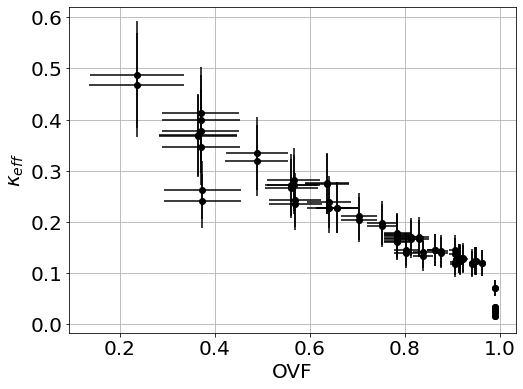

In [2]:
pylab.figure(figsize=(8,6))
pylab.rcParams.update({'font.size':20})

ds = np.loadtxt("data/bcary_dark.csv",skiprows=1,delimiter=",")
r_dry = ds[:,0]/2*1e-9
ovf = np.minimum(ds[:,1], 0.99)
d_ovf = ds[:,2]
kappa_eff = ds[:,3]
d_kappa_eff = ds[:,4]
T = 300 * si.K

datay = kappa_eff
errory = d_kappa_eff

args = [T, r_dry, ovf]

pylab.errorbar(ovf, kappa_eff, yerr=d_kappa_eff, xerr=d_ovf, fmt='ko')
pylab.xlabel("OVF")
pylab.ylabel("$\kappa_{eff}$")
pylab.rcParams.update({'font.size':20})
pylab.grid()
pylab.show()

In [ ]:
from importlib import reload
import kappa_mcmc_ruehl
reload(kappa_mcmc_ruehl)
from kappa_mcmc_ruehl import param_transform, get_model, MCMC

c = AerosolBetaCary(ovf)
params = [15.1, -12.0, 3.3, 0.8]
stepsize = [0.1, 0.05, 0.01, 0.05]
print(param_transform(params))

n_steps = 200
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=NumbaExperimentalFeatureWarning)
    param_chain, accept_chain, chi2_chain = MCMC(params, stepsize, args, datay, errory, n_steps)
#print(param_chain[:,-1])
p = param_transform(param_chain)
print(p[:,-1])

[1.51000000e-19 6.14421235e-06 2.71126389e+01 8.00000000e+16]


In [ ]:
pylab.plot(p[0,:])
pylab.ylabel("A0")
pylab.show()
pylab.plot(p[1,:])
pylab.ylabel("C0")
pylab.show()
pylab.plot(p[2,:])
pylab.ylabel("sgm_min")
pylab.show()
pylab.plot(p[3,:])
pylab.ylabel("m_sigma")
pylab.show()

### Surface tension

In [ ]:
reload(kappa_mcmc_ruehl)
from kappa_mcmc_ruehl import param_transform, negSS
from kappa_mcmc_ruehl import get_model
from scipy.optimize import minimize_scalar, minimize

dat = np.zeros((len(ovf),4))

c = AerosolBetaCary(ovf)
f_org = c.aerosol_modes_per_cc[0]['f_org']
kappa = c.aerosol_modes_per_cc[0]['kappa']['SL']

pylab.figure(figsize=(10,6))

# before
p = param_transform(param_chain[:,0])
print(p)

formulae_1 = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': c.aerosol_modes_per_cc[0]['nu_org'][0],
        'RUEHL_A0': p[0] * si.m * si.m,
        'RUEHL_C0': p[1],
        'RUEHL_sgm_min': p[2] * si.mN / si.m,
        'RUEHL_m_sigma': p[3] * si.J / si.m**2
    }
)
Scrit, rcrit = np.zeros(len(r_dry)), np.zeros(len(r_dry))
for i, rd in enumerate(r_dry):
    a = [formulae_1, T, r_dry[i], kappa[i], f_org[i]]
    res = minimize_scalar(negSS, args=a)
    Scrit[i], rcrit[i] = -1*res.fun, res.x
kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w

s = np.argsort(ovf)
dat[:,0] = ovf[s]
dat[:,2] = kap_eff[s]
pylab.plot(ovf[s], kap_eff[s], 'b:', label="before")

# after
p = param_transform(param_chain[:,-1])
print(p)

formulae_2 = Formulae(
    surface_tension='SzyszkowskiLangmuir',
    constants={
        'RUEHL_nu_org': c.aerosol_modes_per_cc[0]['nu_org'][0],
        'RUEHL_A0': p[0] * si.m * si.m,
        'RUEHL_C0': p[1],
        'RUEHL_sgm_min': p[2] * si.mN / si.m,
        'RUEHL_m_sigma': p[3] * si.J / si.m**2
    }
)
Scrit, rcrit = np.zeros(len(r_dry)), np.zeros(len(r_dry))
for i, rd in enumerate(r_dry):
    a = [formulae_2, T, r_dry[i], kappa[i], f_org[i]]
    res = minimize_scalar(negSS, args=a)
    Scrit[i], rcrit[i] = -1*res.fun, res.x
kap_eff2 = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w

s = np.argsort(ovf)
dat[:,3] = kap_eff2[s]
pylab.plot(ovf[s], kap_eff2[s], 'r-', label="after")

# data
s = np.argsort(ovf)
dat[:,1] = kappa_eff[s]
pylab.errorbar(ovf, kappa_eff, yerr=errory, xerr=d_ovf, fmt='ko')

#pylab.colorbar(label="Dry radius (nm)")
pylab.legend()
pylab.xlabel("Organic Volume Fraction")
pylab.ylabel("$\kappa_{eff}$",fontsize=20)
pylab.rcParams.update({"font.size":15})
pylab.grid()
pylab.savefig("Ruehl_fit_bcary_dark.png", facecolor='w', dpi=200)
pylab.show()

pylab.figure(figsize=(10,6))
pylab.errorbar(kap_eff, kappa_eff, yerr=errory, fmt='bo', label="before")
pylab.errorbar(kap_eff2, kappa_eff, yerr=errory, fmt='ro', label="after")
pylab.legend()
pylab.xlabel("$\kappa_{eff}$ modeled",fontsize=20)
pylab.ylabel("$\kappa_{eff}$ measured",fontsize=20)
pylab.plot([-0.05,0.55],[-0.05,0.55], 'k-')
pylab.xlim([-0.05,0.55])
pylab.ylim([-0.05,0.55])
pylab.rcParams.update({"font.size":15})
pylab.grid()
pylab.show()

# print(dat)
# np.savetxt("Ryan_mcmc.csv", dat, delimiter=',', fmt='%.4f', 
#            header='OVF, Kappa meas, Kappa before, Kappa after', 
#            comments='before: 44.82, 0.61 // after: 34.77, 1.73\n')

In [ ]:
print(param_chain[:,-1])